
### GPT1 Implemented with NumPy : Generate Jokes

I love implementing DL algorithms with NumPy, it's best way to learn the engine. I've implemented SHAP, and CNNs, and GradCAM methods with pure numpy before, you can refer to my Github Page for this.

One can go with Jax, but I prefer going with NumPy, it feels I solve the algorithm with pen and paper.

And this is not the first time it's implemented, I'm late to the LLM train and here are probably some better works:

https://github.com/likejazz/llama3.np

https://thellm.substack.com/p/llama-3-implemented-in-pure-numpy

https://medium.com/@kudoysl/build-your-own-chatgpt-from-scratch-in-python-numpy-9401acd68af5

https://www.youtube.com/watch?v=kCc8FmEb1nY

And definitely I've taken some parts from these amazing guys/gals.


Note that:
- I'll first only focus on feedforward. Then I'll implement backprop.
- I can use tons of for loops to be more descriptive on the algorithms. I know there are faster matrix operations but if I needed them I would be using Jax or PyTorch. I just need to learn details atm.


#### And a special note:
I've implemented the backprop, however, either sth wrong with backpropagation technique, or training, so I'll defer to fixing the backpropagation to other blog post unfortunately. Anyone would like to help me, I can happily host a second part of the blog post together, also can host it on my Youtube Channel.

### Architecture

It's already complicated, but we'll implement one by one. At first we'll implement the easier version:

- Simple encoder
- Single Block Transformer with:
- 1. Single Attention
- 2. Single layer


Then we'll implement the near-complete one with:
- Real encoder
- Multi-head attention



### Import Numpy :)




In [ ]:
import numpy as np

#### Get data

I'll use jokes dataset.

In [16]:
import requests

# URL of the text file
url = "https://raw.githubusercontent.com/yesinteractive/dadjokes/master/controllers/jokes.txt"

# Send a GET request to fetch the content of the text file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the text content from the response
    text_content = response.text

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


In [17]:
print(text_content[0:200])

What did one pirate say to the other when he beat him at chess?<>Checkmatey.
I burned 2000 calories today<>I left my food in the oven for too long.
I startled my next-door neighbor with my new electri


What an ugly series of jokes.

## Tokenize

Let's tokenize as simple as possible, tokenize each word. Character-based tokenization will slow training, word-based tokenization may not work well, but we want to train fast in order to learn.

We can touch to the tokenization later, I want to focus on the model first.



In [18]:
text_content = text_content.lower().replace("\n", " ").replace("<>", " <> ").replace(".", " . ").replace("'","").replace(",","").replace("?","")

text_content += " - " # Don't ask why, it's needed for the tutorial

Bunch of character replacements are for, we are using a very basic tokenization and I don't want to be able to tokenize a word by a character. Otherwise I'll tokenize

- What's
- What

in a different token. Currently I'll make things easier for tokenization. Just don't care and focus on deep learning part.

In [19]:
text_content[:200]

'what did one pirate say to the other when he beat him at chess <> checkmatey .  i burned 2000 calories today <> i left my food in the oven for too long .  i startled my next-door neighbor with my new '

In [20]:
words_in_order = text_content.split(" ") # split the words by " "
corpus = list(set(words_in_order))

print("We have", len(corpus), "unique words and total of" ,len(words_in_order), "words."   )


vocab_size = len(corpus)
print("Vocabulary size:",vocab_size)




We have 1152 unique words and total of 4370 words.
Vocabulary size: 1152


So to encode, we'll create a lookup table(dict in python) that assigns words to integers, in an order

In [21]:
# I'm writing simplistic idiotic code atm. Don't worry I won't be cool if I use character encoding.
lookup_table = {}

for i in range(len(corpus)):
  lookup_table[corpus[i] ] = i

Lookup table now looks like

In [22]:
 {k: lookup_table[k] for k in sorted(lookup_table.keys())[:10]}

{'': 0,
 '"first': 638,
 '"is': 146,
 '"no': 134,
 '"would': 343,
 '-': 779,
 '.': 593,
 '0': 955,
 '1': 377,
 '1023mb': 965}

In [23]:
def encode(str_):
  words = str_.lower().split()
  return [lookup_table[i] for i in words]

The below is encoded to:
What did one pirate say to the other when he beat him at chess

In [24]:
encoded_word = encode("What did one pirate say to the other when he beat him at chess")
print(encoded_word)

[462, 700, 339, 257, 632, 1066, 665, 597, 903, 620, 969, 649, 469, 509]


In [25]:
def decode(list_):
  inv_map = {v: k for k, v in lookup_table.items()}
  return " ".join([inv_map[i] for i in list_])

Will be decoded to

In [26]:
print(decode(encoded_word))

what did one pirate say to the other when he beat him at chess


That's sufficient for tokenization until and unless we want to implement token algorithms with numpy.


### Embedding

Embedding is not a new phenomenon in computer science(at least in ML upon my experience).

AWS documentation explains embedding the best: convert raw data into continuous values that ML models can interpret.

Forget about LLMs, I was working on time series forecasting while ago, and the most important thing to embed dates, or weekends right, because on weekends you sell less may be? Such a feature that converts raw concepts to a mathematical language can be beneficial.
- [1,0,0,0,0,0,0],[0,1,0,0,0,0,0] -> Monday, Tuesday
- [1,0],[0,1] -> Weekdays, Weekend

As you see, for each concept you define a "vector", so that your model can discriminate one from another. And as you notice, we have number of features, meaning we have number of embeddings. Weekdays, Weekend, there are 2 features and we have a size of 2.

But, if we have 10 million words, will we create 10 million size of [0,1,0,0,0,0,0] ? Shallow speaking, Computer memories are not able to process these sizes easily. So we can transform into something simpler.

We can just place these vectors in smaller space, we'll visualise afterwards.

If you *really* want to dive on how these beautiful idea works, learn about dimensionality reduction, and manifold learning(advanced).


Shape of linear layer is  (1152, 2)
This is the encodings of a word what :  [462]
This is the encodings of a word is :  [917]
This is the encodings of a word the :  [665]


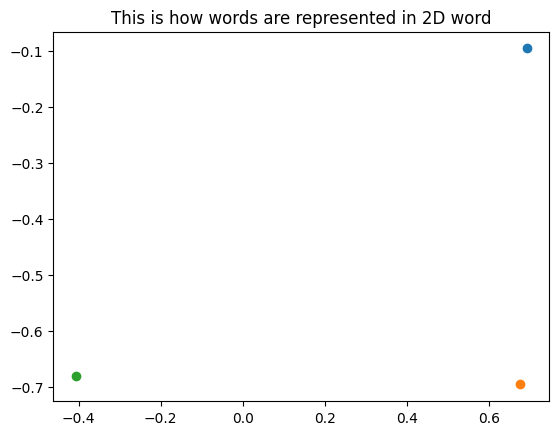

In [27]:
def create_linear_layer(input_size,output_size):
  return np.random.normal(size=[input_size,output_size]) # There are tons of reasons we use a distribution

from matplotlib import pyplot as plt


embedding_layer = create_linear_layer(vocab_size, 2)

print("Shape of linear layer is ", embedding_layer.shape )

sample_sentence = "what is the"

for i in sample_sentence.split(" "):

  print("This is the encodings of a word", i, ": ",  encode(i) )
  plt.scatter(*embedding_layer[encode(i)[0]])
plt.title("This is how words are represented in 2D word")
plt.show()

If we want the visualisation in 3D:

Encoding of the word: what :  462 and it's embedding is : [-3.23213394  0.37801176 -0.12389232]
Encoding of the word: is :  917 and it's embedding is : [ 1.69683877e+00 -1.72843324e-03 -2.35552018e+00]
Encoding of the word: the :  665 and it's embedding is : [-0.78150027  1.32962807  0.46034763]


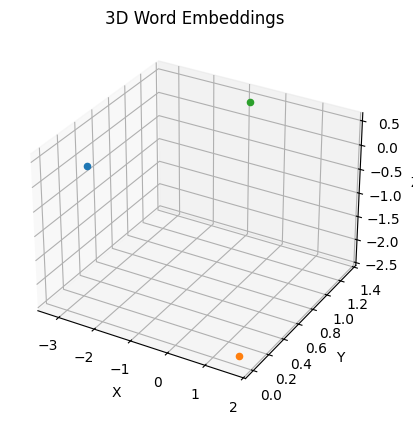

Let's set the embedding to 20, I think it's sufficient for 1300 unique words, enough to capture the space


In [28]:
from matplotlib import pyplot as plt


embedding_layer = create_linear_layer(vocab_size, 3)

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each word in the sample sentence
for word in sample_sentence.split(" "):
    encoded_word = encode(word)[0]
    print("Encoding of the word:", word, ": ", encoded_word, "and it's embedding is :", embedding_layer[encoded_word])
    ax.scatter(*embedding_layer[encoded_word])

# Set titles and labels
ax.set_title("3D Word Embeddings")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()



print("Let's set the embedding to 20, I think it's sufficient for 1300 unique words, enough to capture the space")
embedding_dims = 20

embedding_layer = create_linear_layer(vocab_size, embedding_dims)

So we'll

- index an embedding by indexing the linear layer matrix.
- means that if I'ld like to get embedding of word "what" which has encoding of 1056, i'll get matrix[1056]
- our model will learn how to embed with linear layer, and how to separate this words(not necessarily though but let's assume that). Check this out : https://medium.com/@gautam.e/what-is-nn-embedding-really-de038baadd24


We'll touch to the gradient descents at the veeery end, to not confuse anything. And we'll try to visualise them during training as well.

### Positional Encoding

If you've seen an LSTM implementation, you may have noticed that it's taking the inputs in an order, one by one. This may be the reason why they weren't so successful(not sure though, I need to literature search on the effect of pos. encoding on LSTMs if a new architecture is implemented).

Simply what we try to achieve is to teach model that there's an order of words. We can normally simply introduce by

0,1,2,3,4,5,6,7

but one thing that DL models generally don't like is the exploited/limitless outputs during feedforwards(see vanishing gradient, or see why do we need initialisations such as Xu otherwise model is not training properly. So to introduce orders, we'll normalize between 0 and 1, and we'll be introducing these orders with sinus and cosinus.

For better explanation see : https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6




In [29]:
print(sample_sentence)
len_sentence = len(encode(sample_sentence))
print("encoded to: ", encode(sample_sentence ))


def positional_encoder(len_sentence,embedding_dim, vocab_size):
  pos_encode_word = np.zeros((len_sentence, embedding_dim))
  for pos_word in range(len_sentence):
      for i in range(0, embedding_dim, 2):
          # Apply sine to even dimensions
          pos_encode_word[pos_word, i] = np.sin(pos_word / (vocab_size ** ((2 * i)/embedding_dim)))
          # Apply cosine to odd dimensions
          if i + 1 < embedding_dim:
              pos_encode_word[pos_word, i + 1] = np.cos(pos_word / (vocab_size ** ((2 * (i + 1))/embedding_dim)))

  return pos_encode_word


positional_encodings = positional_encoder(len_sentence, embedding_dims, vocab_size)
print(positional_encodings.shape)

what is the
encoded to:  [462, 917, 665]
(3, 20)


I'll add more on this, how did I choose parameters.

Along with our word embeddings, when we sum it with embeddings, sum of them will both preserve the position of words and the semantic meaning of the word of interest.

So we need to sum them according to the architecture. But how?

![GPT Architecture](https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Full_GPT_architecture.svg/1280px-Full_GPT_architecture.svg.png)




### Context Window or Sequence Length

In order to sum the positional encoding and token embeddings up, we need to discuss on the dimensions.

We said that
1. We take a sentence. ("what is the")
2. We encode each word, three words so we'll have 3 embeddings for this example.
3. We embed the words of sentence by passing it through linear layer(or embedding layer) (3,30), (no_of_words, embedding_dims)
4. The length of the token embeddings (number of tokens in the sequence) and the positional encodings must match, i.e., the sequence length.
5. The dimensionality of the token embeddings and positional encodings must also be the same, i.e., the embedding dimension.
6. So positional encoding is also (3,30), and we just sum them.

In [30]:
print("Sentence:",sample_sentence)
idxs = encode(sample_sentence)
positionally_encoded_tokens = embedding_layer[idxs,:] + positional_encoder(len_sentence, embedding_dims, vocab_size)
print("shape of the sentence after positional encoding is added: ", positionally_encoded_tokens.shape)




Sentence: what is the
shape of the sentence after positional encoding is added:  (3, 20)


### Dropout

Dropout is with us since 2014, it was very popular for CNNs for a while to avoid overfitting, but then it lost its popularity on that manner since there are better methods, but it's still with us with more impact.

- Yeah it lost it's popularity around 2016, it's not lie, check this out : https://www.reddit.com/r/MachineLearning/comments/5l3f1c/d_what_happened_to_dropout/

- Surprising paper, "Dropout reduces overfitting" : https://arxiv.org/pdf/2303.01500


You can read the history of dropouts https://medium.com/unpackai/introduction-of-dropout-and-ensemble-model-in-the-history-of-deep-learning-a4c2a512dcca , and my weird way of using dropouts in a Kaggle competitions where I failed heavily https://www.kaggle.com/code/mburaksayici/ensembling-nns-inside-single-nn-for-fast-inference .



In [31]:
def dropout(X, dropout_rate=0.2):
    # Create a random mask with the same shape as X
    mask = np.random.binomial(1, 1 - dropout_rate, size=X.shape) # either 1 or 0
    # Scale and apply mask
    X_dropped = X * mask / (1 - dropout_rate)
    return X_dropped


dropout_vectors = dropout(positionally_encoded_tokens, dropout_rate=0.2)

### Initialisation of Weights

Attention weights we'll talk later is initialised as Xavier, see the discussion : https://ai.stackexchange.com/questions/30491/is-there-a-proper-initialization-technique-for-the-weight-matrices-in-multi-head

In [32]:
def xavier_initialization(n_in, n_out):

    limit = np.sqrt(6 / (n_in + n_out))  # Compute the Xavier scaling factor
    return np.random.uniform(-limit, limit, size=(n_in, n_out))




### Transformer Model

I advise you to watch https://www.youtube.com/watch?v=eMlx5fFNoYc.

#### Attention

Let's start with attention. Or "Single-Head Attention", or "Scaled Dot-Product Attention".  

- About masks : https://pi-tau.github.io/posts/transformer/#attention

In [33]:


def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)


def attention(X,W_Q,W_K,W_V):
    Q = np.dot(X, W_Q)  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]
    K = np.dot(X, W_K)  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]
    V = np.dot(X, W_V)  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]

    mask = (1 - np.tri(X.shape[0], dtype=X.dtype)) * -1e10  # [n_seq, n_seq]

    scores = softmax (   (  np.dot(Q, K.T )  / np.sqrt(Q.shape[-1])    )   + mask    ) # [n_seq, n_embd]
    return np.dot(scores, V)  # [n_seq, n_embd]




# We have Query, Key, Value matrices, can be initialised with xavier with embedding_dims set above.

W_Q = xavier_initialization(embedding_dims,embedding_dims) # weights of q
W_K = xavier_initialization(embedding_dims,embedding_dims)
W_V = xavier_initialization(embedding_dims,embedding_dims)

out = attention(dropout_vectors, W_Q,W_K,W_V )


### Layer Normalization with Residual Connection
As it's said before on initialisation, if the layer outputs doesn't have some kind of a mathematical standard, it's hard for model to learn, or correctly update the weights with gradient descent.

Layer normalisation is simply ensuring output of models are having
- mean of 0
- standard deviation of 1

You can research about it, but it's simply:
- Assume you have a vector(or layer, or weights, or matrix, or tensor, whatever you want) that is [0, 5, 10].
- Take the mean, which is 5, substract it from all, [-5 , 0 , 5], now the mean is 0.
- Calculate the standard deviation, which means sqrt ( sum( (x_i -mean )**2 ) / size-1  ) = sqrt ( 5^2 + 0^2 + -5^2   / 2 ) = sqrt (50/2) = 5
- Divide all with 5, [-5/5 , 0/5, 5/5] = [1, 0, 1]

That's how it's work. And its the topic of statistics





And residual connection is a method of ResNet's, i dont have if it dates back before that, we sum the output of layer with its input to again ensure numerical stability. See Visualizing the Loss Landscape of Neural Nets: https://papers.nips.cc/paper_files/paper/2018/file/a41b3bb3e6b050b6c9067c67f663b915-Paper.pdf





In [34]:
def residual_norm(X, attention_out, epsilon=1e-6):
    residual = X + attention_out  # Residual connection
    mean = np.mean(residual, axis=-1, keepdims=True)
    var = np.var(residual, axis=-1, keepdims=True)
    normalized = (residual - mean) / np.sqrt(var + epsilon)  # Layer normalization
    return normalized


residual_norm_after_attention = residual_norm(dropout_vectors,out, )

In [35]:
residual_norm_after_attention.shape

(3, 20)

### Feedforward Network


In [36]:


linear_after_attention_1 = create_linear_layer(20,40)
linear_after_attention_2 =  create_linear_layer(40,20 )


def feedforward(X, W1, W2, b1=0, b2=0):
    # First linear layer
    hidden = np.maximum(0, np.dot(X, W1) + b1)  # ReLU activation
    # Second linear layer
    output = np.dot(hidden, W2) + b2
    return output


feedforward_out = feedforward(residual_norm_after_attention, linear_after_attention_1, linear_after_attention_2, b1=0, b2=0)


print("Feedforward Shape:", feedforward_out.shape)

Feedforward Shape: (3, 20)


And again we will have residual skips

In [37]:
final_out = residual_norm(residual_norm_after_attention,feedforward_out)

We are done with final output. It give us  (3,20) (seq_len,n_emb) size of output. And we need to convert it back to sentence/or word, simply we are decoding.


Remember we have embedding layer of vocab_size,embedding dim. (1151, 20)

We want to have 3,1151 vector to get probabilities(if you apply softmax, logits if you dont) for all words.


Trick is just
final_out*embedding_layer.T

(3,20) dot (20,1551) = (3,1151)

In [38]:
prediction = np.dot(final_out,embedding_layer.T)
print(prediction.shape)



(3, 1152)


Here's our first output without training.

In [39]:
print(decode(prediction.argmax(1)))

prisoners prisoners promoted


### Generate Sentence

Let's wrap all up

In [40]:
import numpy as np
import requests

class GPT1Numpy:
    def __init__(self, vocab_size, lookup_table, embedding_dim, max_seq_len):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.lookup_table = lookup_table

        # Initialize embeddings, positional encodings, and attention weights
        self.embedding_layer = self.create_linear_layer(vocab_size, embedding_dim)
        self.W_Q = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W_K = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W_V = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W1 = self.xavier_initialization(embedding_dim, embedding_dim)  # Feedforward layer weights
        self.W2 = self.xavier_initialization(embedding_dim, embedding_dim)  # Feedforward layer weights
        self.b1 = np.zeros(embedding_dim)  # Feedforward layer biases
        self.b2 = np.zeros(embedding_dim)  # Feedforward layer biases

    def encode(self, str_):
        words = str_.lower().split()
        return [self.lookup_table[i] for i in words]

    def decode(self, list_):
        inv_map = {v: k for k, v in self.lookup_table.items()}
        return " ".join([inv_map[i] for i in list_])

    def create_linear_layer(self, input_size, output_size):
        return np.random.normal(size=[input_size, output_size])

    def xavier_initialization(self, n_in, n_out):
        limit = np.sqrt(6 / (n_in + n_out))
        return np.random.uniform(-limit, limit, size=(n_in, n_out))

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exps / np.sum(exps, axis=-1, keepdims=True)

    def attention(self, X):
        Q = np.dot(X, self.W_Q)
        K = np.dot(X, self.W_K)
        V = np.dot(X, self.W_V)

        mask = (1 - np.tri(X.shape[0], dtype=X.dtype)) * -1e10
        scores = self.softmax((np.dot(Q, K.T) / np.sqrt(Q.shape[-1])) + mask)
        return np.dot(scores, V)

    def positional_encoder(self, len_sentence):
        pos_encode_word = np.zeros((len_sentence, self.embedding_dim))
        for pos_word in range(len_sentence):
            for i in range(0, self.embedding_dim, 2):
                pos_encode_word[pos_word, i] = np.sin(pos_word / (self.vocab_size ** (2 * i / self.embedding_dim)))
                if i + 1 < self.embedding_dim:
                    pos_encode_word[pos_word, i + 1] = np.cos(pos_word / (self.vocab_size ** (2 * (i + 1) / self.embedding_dim)))
        return pos_encode_word

    def residual_norm(self, X, attention_out, epsilon=1e-6):
        residual = X + attention_out  # Residual connection
        mean = np.mean(residual, axis=-1, keepdims=True)
        var = np.var(residual, axis=-1, keepdims=True)
        normalized = (residual - mean) / np.sqrt(var + epsilon)  # Layer normalization
        return normalized

    def feedforward(self, X, W1, W2, b1=0, b2=0):
        # First linear layer
        hidden = np.maximum(0, np.dot(X, W1) + b1)  # ReLU activation
        # Second linear layer
        output = np.dot(hidden, W2) + b2
        return output

    def forward(self, sentence):
        # Encode the sentence
        encoded_sentence = self.encode(sentence)

        # Get embeddings and positional encodings
        token_embeddings = self.embedding_layer[encoded_sentence]
        pos_encodings = self.positional_encoder(len(encoded_sentence))

        # Add positional encodings to token embeddings
        X = token_embeddings + pos_encodings

        # Pass through the attention layer
        attention_output = self.attention(X)

        # Apply residual layer normalization
        X_normalized = self.residual_norm(X, attention_output)

        # Pass through the feedforward network
        output = self.feedforward(X_normalized, self.W1, self.W2, self.b1, self.b2)

        return output

    def predict_next_word(self, current_sequence):

        attention_output = self.forward(current_sequence)
        predicted_word_idx = np.argmax(np.sum(attention_output, axis=0))  # Aggregate to predict
        return self.decode([predicted_word_idx])

    def inference(self, initial_sentence, max_len=10):
        sentence = initial_sentence
        for _ in range(max_len - len(initial_sentence.split())):
            next_word = self.predict_next_word(sentence)
            sentence += " " + next_word
            if next_word == '.':
                break
        return sentence

### Inference Function
Our inference function is simply predicting the next word, choose the most probable one. Note that the temperature mechanism also can be employed one by not chosing the first most probable, but the second, but it's the topic of the next day.



Let's initialise the model with no-backprop.

In [41]:

# Initialize the model
url = "https://raw.githubusercontent.com/yesinteractive/dadjokes/master/controllers/jokes.txt"
response = requests.get(url)
text_content = response.text.lower().replace("\n", " ").replace("<>", " <> ").replace(".", " . ").replace("'","").replace(",","").replace("?","")
words_in_order = text_content.split(" ")
corpus = list(set(words_in_order))

vocab_size = len(corpus)
embedding_dims = 20
max_seq_len = 10

gpt_model = GPT1Numpy(vocab_size=vocab_size, lookup_table=lookup_table,embedding_dim=embedding_dims, max_seq_len=max_seq_len)

# Initialize lookup table
for i in range(len(corpus)):
    gpt_model.lookup_table[corpus[i]] = i



In [42]:
# Perform inference
start_sentence = "what is the"
generated_text = gpt_model.inference(start_sentence, 10)
print(generated_text)

what is the so so so so so so so


Let's leave the training part after some wrap-up discussion and completing the whole GPT with two transformer blocks.

Currently, what we have is single-block of attention with no batching. It simply looks like this.


Image comes here***


There are four things we need to consider:
- Multi-head self attention is missing as well, we implemented single-head.
- There should be 12 blocks of transformers We've implemented a single one. I'm a mercyful person to your CPUs, so we'll only implement two of them.
- We didn't employ any batching yet.
- We'll implement training, backprops as well.


### Full GPT1

### Multi-Head Attention

Multi-Head attention is just kind of ensembling (https://lilianweng.github.io/posts/2018-06-24-attention/):
- On the same input X(pos.enc. + embed.) that we feed-forward to transformer block, instead of operations with single Q K V, and having one # [n_seq, n_embd] shape of output, do the same operation on same input with randomly created Q K V's, let's say 10 of them which are called heads, have # [n_seq, n_embd, n_head=10], then average all to have # [n_seq, n_embd]
- Since we know that the logic of attention we wrote on single-head works, ensemble of results will also work.
- It's kinda like having multiple kernels in same layer of CNNs. Just like we know that CNN kernels focus on different features of the image, some of the heads focus on verbs, some of them are on adjectives. ( https://aclanthology.org/W19-4828.pdf )
** add image from same paper

Nice discussion on that : https://stackoverflow.com/questions/66244123/why-use-multi-headed-attention-in-transformers

#### number of attention heads (n_embd must be divisible by n_head)?
I was confused by the statement of " number of attention heads (n_embd must be divisible by n_head)? " from jaykmody's blog.

https://stackoverflow.com/questions/66244123/why-use-multi-headed-attention-in-transformers

And the reason is explained as "Instead of using a single attention function where the attention can be dominated by the actual word itself, transformers use multiple attention heads."

#### How multi-head works?

We set the parameters as:


- n_embd: This is the embedding dimension, or the size of the vector representing each token (in your example, 30).
- n_head: The number of attention heads in multi-head attention (let’s assume 3 heads for this explanation).
- n_seq: The number of tokens, or number of words in "what is the".

Single-head attention works as:

1. Input matrix,pos.enc + embd., which has a shape of [n_seq, n_embd] ( [3, 20]).
2. We project this matrix into Q,K,V  matrices, which also have the shape [3, 20].
3. After applying the attention mechanism, the attention scores are computed, and the output of the attention is of shape [3, 20].

Whereas Multi-head attention:

1. We split embedding across heads evenly. If we have 3 heads, we want each head to focus on a portion of the embedding.
If n_embd = 20 and n_head = 4, each head will get a portion of the embedding of size n_embd_per_head = n_embd / n_head = 30 / 3 = 10.
So, instead of working with [3, 20] for the entire attention, each head works with its own portion of embeddings, [3, 5], which is the embedding size allocated to that head.
2. Each head independently computes its own Q,K,V with dimensions [n_seq, n_embd_per_head] for each, which in this case is [3, 5]. This allows each head to focus on different parts of the representation.
The attention operations is applied independently for each head in its reduced dimension space.
3. After each head produces its attention output of shape [3, 5], these outputs are concatenated along the embedding dimension to form a result of shape [3, 20].
4. The concatenated output is then passed through a final linear layer to combine the outputs of the multiple heads into a single output representation of the same shape [n_seq, n_embd] = [3, 20].

Let's implement this and discuss.



In [43]:
import numpy as np


def multihead_attention(X, W_Q, W_K, W_V, n_head):
    n_seq, n_embd = X.shape
    head_dim = n_embd // n_head

    # Split weights for each head
    Q = np.dot(X, W_Q).reshape(n_seq, n_head, head_dim)  # [n_seq, n_embd] -> [n_seq, n_head, head_dim]
    K = np.dot(X, W_K).reshape(n_seq, n_head, head_dim)  # [n_seq, n_embd] -> [n_seq, n_head, head_dim]
    V = np.dot(X, W_V).reshape(n_seq, n_head, head_dim)  # [n_seq, n_embd] -> [n_seq, n_head, head_dim]

    # Apply attention for each head independently
    multihead_outputs = []

    for i in range(n_head):
        Qi = Q[:, i, :]  # [n_seq, head_dim]
        Ki = K[:, i, :]  # [n_seq, head_dim]
        Vi = V[:, i, :]  # [n_seq, head_dim]

        mask = (1 - np.tri(n_seq, dtype=X.dtype)) * -1e10  # [n_seq, n_seq]

        # Calculate attention scores and apply softmax
        scores = softmax((np.dot(Qi, Ki.T) / np.sqrt(head_dim)) + mask)  # [n_seq, n_seq]

        # Compute weighted sum of values
        head_output = np.dot(scores, Vi)  # [n_seq, head_dim]

        multihead_outputs.append(head_output)

    # Concatenate outputs from all heads
    multihead_output = np.concatenate(multihead_outputs, axis=-1)  # [n_seq, n_embd] (back to original dimension)

    return multihead_output


# Example usage:
n_seq = 3
embedding_dims = 20
n_head = 4  # Number of attention heads

# Initialize X (input embeddings), and Q, K, V weight matrices
X = dropout_vectors
W_Q = xavier_initialization(embedding_dims, embedding_dims)
W_K = xavier_initialization(embedding_dims, embedding_dims)
W_V = xavier_initialization(embedding_dims, embedding_dims)

# Perform multi-head attention
output = multihead_attention(X, W_Q, W_K, W_V, n_head)
print(output.shape)  # Should be [n_seq, embedding_dims], e.g., [3, 20]


(3, 20)


#### Two blocks of transformers

Let's iterate the block for two.

In [328]:

class GPT1Numpy_2TransformerBlock:
    def __init__(self, vocab_size, lookup_table, embedding_dim, max_seq_len, num_heads=4):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.lookup_table = lookup_table
        self.num_heads = num_heads

        # Initialize embeddings, positional encodings, and attention weights
        self.embedding_layer =self.xavier_initialization(vocab_size, embedding_dim) #  self.create_linear_layer(vocab_size, embedding_dim)

        # Transformer block 1
        self.W_Q = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W_K = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W_V = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W1 = self.xavier_initialization(embedding_dim, embedding_dim)  # Feedforward layer weights
        self.W2 = self.xavier_initialization(embedding_dim, embedding_dim)  # Feedforward layer weights
        self.b1 = np.zeros(embedding_dim)  # Feedforward layer biases
        self.b2 = np.zeros(embedding_dim)  # Feedforward layer biases

        # Transformer block 2
        self.W_Q_2 = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W_K_2 = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W_V_2 = self.xavier_initialization(embedding_dim, embedding_dim)
        self.W1_2 = self.xavier_initialization(embedding_dim, embedding_dim)  # Feedforward layer weights
        self.W2_2 = self.xavier_initialization(embedding_dim, embedding_dim)  # Feedforward layer weights
        self.b1_2 = np.zeros(embedding_dim)  # Feedforward layer biases
        self.b2_2 = np.zeros(embedding_dim)  # Feedforward layer biases


    def encode(self, str_):
        words = str_.lower().split()
        return [self.lookup_table[i] for i in words]

    def decode(self, list_):
        inv_map = {v: k for k, v in self.lookup_table.items()}
        return " ".join([inv_map[i] for i in list_])

    def create_linear_layer(self, input_size, output_size):
        return np.random.normal(size=[input_size, output_size])

    def xavier_initialization(self, n_in, n_out):
        limit = np.sqrt(6 / (n_in + n_out))
        return np.random.uniform(-limit, limit, size=(n_in, n_out))

    def positional_encoder(self, len_sentence):
        pos_encode_word = np.zeros((len_sentence, self.embedding_dim))
        for pos_word in range(len_sentence):
            for i in range(0, self.embedding_dim, 2):
                pos_encode_word[pos_word, i] = np.sin(pos_word / (self.vocab_size ** (2 * i / self.embedding_dim)))
                if i + 1 < self.embedding_dim:
                    pos_encode_word[pos_word, i + 1] = np.cos(pos_word / (self.vocab_size ** (2 * (i + 1) / self.embedding_dim)))
        return pos_encode_word

    def full_encode(self,sentence):
        # Encode the sentence
        encoded_sentence = self.encode(sentence)

        # Get embeddings and positional encodings
        token_embeddings = self.embedding_layer[encoded_sentence]
        pos_encodings = self.positional_encoder(len(encoded_sentence))

        # Add positional encodings to token embeddings
        X = token_embeddings + pos_encodings
        return X

    def residual_norm(self, X, attention_out, epsilon=1e-6):
        residual = X + attention_out  # Residual connection
        mean = np.mean(residual, axis=-1, keepdims=True)
        var = np.var(residual, axis=-1, keepdims=True)
        normalized = (residual - mean) / np.sqrt(var + epsilon)  # Layer normalization
        return normalized

    def feedforward(self, X, W1, W2, b1=0, b2=0):
        # First linear layer
        hidden = np.maximum(0, np.dot(X, W1) + b1)  # ReLU activation
        # Second linear layer
        output = np.dot(hidden, W2) + b2
        return output

    def multihead_attention(self, X, W_Q, W_K, W_V, n_head):
        n_seq, n_embd = X.shape
        head_dim = n_embd // n_head

        # Split weights for each head
        Q = np.dot(X, W_Q).reshape(n_seq, n_head, head_dim)  # [n_seq, n_embd] -> [n_seq, n_head, head_dim]
        K = np.dot(X, W_K).reshape(n_seq, n_head, head_dim)  # [n_seq, n_embd] -> [n_seq, n_head, head_dim]
        V = np.dot(X, W_V).reshape(n_seq, n_head, head_dim)  # [n_seq, n_embd] -> [n_seq, n_head, head_dim]

        # Apply attention for each head independently
        multihead_outputs = []

        for i in range(n_head):
            Qi = Q[:, i, :]  # [n_seq, head_dim]
            Ki = K[:, i, :]  # [n_seq, head_dim]
            Vi = V[:, i, :]  # [n_seq, head_dim]

            mask = (1 - np.tri(n_seq, dtype=X.dtype)) * -1e10  # [n_seq, n_seq]

            # Calculate attention scores and apply softmax
            scores = softmax((np.dot(Qi, Ki.T) / np.sqrt(head_dim)) + mask)  # [n_seq, n_seq]

            # Compute weighted sum of values
            head_output = np.dot(scores, Vi)  # [n_seq, head_dim]

            multihead_outputs.append(head_output)

        # Concatenate outputs from all heads
        multihead_output = np.concatenate(multihead_outputs, axis=-1)  # [n_seq, n_embd] (back to original dimension)

        return multihead_output

    def transformer_block(self, X):
        # Pass through the multi-head attention layer
        attention_output = self.multihead_attention(X, self.W_Q, self.W_K, self.W_V, self.num_heads)

        # Apply residual layer normalization
        X_normalized = self.residual_norm(X, attention_output)

        # Pass through the feedforward network
        output = self.feedforward(X_normalized, self.W1, self.W2, self.b1, self.b2)
        #print(self.W1.max(), self.W1.min(), self.W1.mean())
        return output

    def transformer_block_2(self, X):
        # Pass through the multi-head attention layer
        attention_output = self.multihead_attention(X, self.W_Q_2, self.W_K_2, self.W_V_2, self.num_heads)

        # Apply residual layer normalization
        X_normalized = self.residual_norm(X, attention_output)

        # Pass through the feedforward network
        output = self.feedforward(X_normalized, self.W1_2, self.W2_2, self.b1_2, self.b2_2)
        return output




    def forward(self, sentence):

        X = self.full_encode(sentence)
        ## Assume there's for loop in here
        X = self.transformer_block(X,)
        X = self.transformer_block_2(X,)
        X = self.softmax(X)

        return X

    """def forward(self, sentence):
        X = self.full_encode(sentence)
        X = self.transformer_block(X)
        X = self.transformer_block_2(X)
        
        # Project to vocabulary size with a bias towards exact input
        X = np.dot(X, 10)
        X = self.softmax(X)
    
        return X"""

    
    def predict_next_word(self, current_sequence):
        # import pdb;pdb.set_trace()

        attention_output = self.forward(current_sequence)
        predicted_word_idx = np.argmax(np.sum(attention_output, axis=0))  # Aggregate to predict
        return self.decode([predicted_word_idx])
    

    def inference(self, initial_sentence, max_len=10):
        sentence = initial_sentence
        for _ in range(max_len - len(initial_sentence.split())):
            next_word = self.predict_next_word(sentence)
            sentence += " " + next_word
            if next_word == '.':
                break
        return sentence


    def softmax(self, logits):
        exps = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
        return exps / np.sum(exps, axis=-1, keepdims=True)

    def cross_entropy_loss(self, predictions, targets):
        # Compute cross-entropy loss
        n_samples = predictions.shape[0]
        correct_log_probs = -np.log(predictions[np.arange(n_samples), targets])
        loss = np.sum(correct_log_probs) / n_samples
        return loss

    def backward(self, output, X, lr=0.001):
        # Gradient of feedforward network and attention layers
        # This assumes that `output` is the result from the forward pass
        n_samples = output.shape[0]

        # Derivative of softmax
        d_output = self.softmax(output)
        #print(d_output.mean())
        d_output[np.arange(n_samples), np.argmax(X, axis=1)] -= 1  # Use X as target (pretraining)

        # Gradient descent update for transformer block 2
        d_hidden = np.dot(d_output, self.W2_2.T)  # Gradient wrt W2_2
        #print(d_hidden.mean())

        d_hidden = np.maximum(0, d_hidden)  # ReLU backward
        #print(d_hidden.mean(), "DHIDDENAFTERRELU")

        self.W2_2 -= lr * np.dot(self.residual_norm(output, d_hidden).T, d_output)
        #print((lr * np.dot(self.residual_norm(output, d_hidden).T, d_output)).mean(), "W2_2")

        self.W1_2 -= lr * np.dot(self.residual_norm(output, d_hidden).T, d_hidden)
        self.b2_2 -= lr * np.sum(d_output, axis=0)
        self.b1_2 -= lr * np.sum(d_hidden, axis=0)

        # Gradient descent update for transformer block 1
        d_hidden = np.dot(d_output, self.W2.T)  # Gradient wrt W2
        d_hidden = np.maximum(0, d_hidden)  # ReLU backward
        self.W2 -= lr * np.dot(self.residual_norm(output, d_hidden).T, d_output)
        self.W1 -= lr * np.dot(self.residual_norm(output, d_hidden).T, d_hidden)
        self.b2 -= lr * np.sum(d_output, axis=0)
        self.b1 -= lr * np.sum(d_hidden, axis=0)
        #print(np.dot(self.residual_norm(output, d_hidden).T, d_output).mean() , "last")
    
    def train(self, sentences, epochs=100, lr=0.001):
        for epoch in range(epochs):
            total_loss = 0
            for sentence in sentences:
                # Forward pass
                X = self.full_encode(sentence)  # Encode input sentence
                output = self.forward(sentence)  # Forward pass through transformer blocks
                #print(output)
                # Backward pass
                self.backward(output, X, lr)  # Backpropagation using output and X as target

                # Loss calculation
                probs = self.softmax(output)
                total_loss += self.cross_entropy_loss(probs, np.argmax(X, axis=1))  # Pretraining target is X



            # start_sentence = "what is"
            #print(self.inference(start_sentence, 15))
            avg_loss = total_loss / len(sentences)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

    
    


# Initialize the model
url = "https://raw.githubusercontent.com/yesinteractive/dadjokes/master/controllers/jokes.txt"
response = requests.get(url)
text_content = response.text.lower().replace("\n", " ").replace("<>", " <> ").replace(".", " . ").replace("'","").replace(",","").replace("?","")
words_in_order = text_content.split(" ")
corpus = list(set(words_in_order))

vocab_size = len(corpus)
embedding_dims = 20
max_seq_len = 10

# Initialize lookup table
lookup_table = {word: i for i, word in enumerate(corpus)}

gpt_model = GPT1Numpy_2TransformerBlock(vocab_size=vocab_size, lookup_table=lookup_table, embedding_dim=embedding_dims, max_seq_len=max_seq_len)

# Perform inference
start_sentence = "what is"
generated_text = gpt_model.inference(start_sentence, 15)
print(generated_text)


what is spelling spelling spelling spelling spelling calendar calendar calendar calendar calendar calendar calendar calendar


### Training

Training is as easy as we call the train function...


In [ ]:
gpt_model.train(["what the hell"],
                lr= 2e-3 , epochs=110) 

## Epoch 1/11, Loss: 2.966768661144718
## Epoch 2/11, Loss: 2.9854325455990236
## Epoch 3/11, Loss: 2.9760104396094147
## Epoch 4/11, Loss: 2.9769194149463067
## Epoch 5/11, Loss: 2.9816522615555834
## Epoch 6/11, Loss: 2.9879932952993618
## Epoch 7/11, Loss: 2.971529127633822
## Epoch 8/11, Loss: 2.9819882464453435
## Epoch 9/11, Loss: 2.980378243176302
## Epoch 10/11, Loss: 2.969979056804577
## Epoch 11/11, Loss: 2.9767269046851466


# Perform inference
start_sentence = "what the hell"
generated_text = gpt_model.inference(start_sentence, 15)
print(generated_text)

### what the hell bigger bigger bigger bigger bigger bigger bigger bigger bigger bigger bigger bigger


### How Backpropagation Works (and How I couldnt make it work)

Training this model, which I kindly request help, I either failed on backpropagation algorithm, or the gradients itself. Or, a training strategy. I thought for a small model and small data, any model should fit.

Loss doesn't decrease to a certain point. 

My plan is to find a JAX implementation,
- check the weights if my initisialisation is correct
- check that the output of the layers are matching with the working implementation on JAX
- check if backpropagation matrices having similar mean/std.
- also check if JAX implementations works with the data.


But to sum up, what I did, and I hope after fixing the backprop, I plan to detail the part below:


#### **a. Gradients of Loss**
1. **Loss Gradient (Output Layer):**
   The gradient of the loss, \(\nabla L\), begins with:
   \[
   \text{d\_output} = \text{softmax}(\text{logits}) - \text{target\_one\_hot}
   \]
   This derivative reflects the error signal for each output neuron.



#### **b. Feedforward Gradient**
For the feedforward network layers in each transformer block:
1. Compute gradients with respect to weights and biases in the output layer:
   \[
   \nabla W2 = \text{X\_normalized}^T \cdot \text{d\_output}, \quad \nabla b2 = \sum(\text{d\_output}, \text{axis}=0)
   \]
2. Backpropagate through the ReLU activation:
   \[
   \text{d\_hidden} = \text{d\_output} \cdot W2^T \quad \text{and apply} \quad \text{ReLU'}(\text{hidden})
   \]
3. Compute the gradients for the first linear layer:
   \[
   \nabla W1 = \text{X}^T \cdot \text{d\_hidden}, \quad \nabla b1 = \sum(\text{d\_hidden}, \text{axis}=0)
   \]

Update the weights and biases using:
   \[
   W2 -= \eta \cdot \nabla W2, \quad b2 -= \eta \cdot \nabla b2
   \]



#### **c. Attention Gradient**
The multi-head self-attention process has additional backpropagation requirements:
1. **Attention Outputs:**
   Gradients flow back to \( Q, K, V \):
   \[
   \text{d\_scores} = \text{softmax(scores)} \cdot \text{d\_attention\_output}
   \]
   Gradients with respect to \( Q, K, V \) are computed using chain rules involving matrix products and derivatives.

2. **Parameter Updates:**
   The weight matrices \( W_Q, W_K, W_V \) are updated based on:
   \[
   W_Q -= \eta \cdot \nabla W_Q, \quad W_K -= \eta \cdot \nabla W_K, \quad W_V -= \eta \cdot \nabla W_V
   \]



#### **d. Residual and Layer Normalization Gradients**
Residual normalization requires computing gradients of the loss with respect to normalized outputs:
1. Compute gradients for the residual connection:
   \[
   \text{d\_residual} = \text{d\_feedforward} + \text{d\_attention}
   \]
2. Backpropagate through normalization:
   \[
   \text{d\_normalized} = (\text{X} - \text{mean}) / \sqrt{\text{var} + \epsilon}
   \]
   The gradients with respect to scale and shift (if present) are also computed.



#### **e. Update Parameters**
All weight matrices (\( W1, W2, W_Q, W_K, W_V, \) etc.) and biases (\( b1, b2 \)) are updated using the learning rate \( \eta \) and corresponding gradients:
\[
\theta := \theta - \eta \cdot \nabla \theta
\]

